# **Assignment 2 - Transformer Architecture**

**Github Link:** https://github.com/Venkata-Murari1711/Generative-AI-model-development.git

### **Importing Libraries**

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import os
import torch
from datasets import load_dataset
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    AutoModelForMaskedLM,
    AutoModelForSeq2SeqLM,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
)

!pip install evaluate
!pip install rouge_score
import evaluate
from transformers import logging

# Silence warnings for cleaner output
logging.set_verbosity_error()

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 5.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rouge_score: filename=rouge_score-0.1.2-py3-none-any.whl size=24934 sha256=871dbbc9d318c8b632c365df01dce89ac8ba8f052fbb3244ce2bad4e267e2e86
  Stored in directory: /root/.cache/pip/wheels/85/9d/af/01feefbe7d55ef5468796f0c68225b6788e85d9d0a281e7a70
Successfully built rouge_score
Using device: cuda


### **Loading Dataset (CNN dailymail)**



In [ ]:
# Load the cnn_dailymail dataset (version 3.0.0)
dataset = load_dataset("cnn_dailymail", "3.0.0")

# Subsample for faster training
train_size = 500
val_size = 100

small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print("Dataset splits:", dataset.keys())
print("Sample training record:\n", small_train_dataset[0])

README.md: 0.00B [00:00, ?B/s]

3.0.0/train-00000-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00001-of-00003.parquet:   0%|          | 0.00/257M [00:00<?, ?B/s]

3.0.0/train-00002-of-00003.parquet:   0%|          | 0.00/259M [00:00<?, ?B/s]

3.0.0/validation-00000-of-00001.parquet:   0%|          | 0.00/34.7M [00:00<?, ?B/s]

3.0.0/test-00000-of-00001.parquet:   0%|          | 0.00/30.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/287113 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/13368 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/11490 [00:00<?, ? examples/s]

Dataset splits: dict_keys(['train', 'validation', 'test'])
Sample training record:
 {'article': "By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a static caravan from carbon monoxide poisoning would have been unconscious 'within minutes', investigators said today. The bodies of married couple John and Audrey Cook were discovered alongside their daughter, Maureen, at the mobile home they shared on Tremarle Home Park in Camborne, west Cornwall. The inquests have now opened into the deaths last Saturday, with investigators saying the three died along with the family's pet dog, of carbon monoxide poisoning from a cooker. Tragic: The inquests have opened into the deaths of three members of the same family who were found in their static caravan last weekend. John and Audrey Cook are pictured . Awful: The family died following carbon monoxide poisoning at this caravan at the Tremarle Home Park in 

## **Decoder‑only model: GPT ‑ 2 fine‑tuning**

A decoder-only transformer must learn to generate a summary given an input article. We use a prompt-based approach: the input text has the form "summarize: <article>\nSummary:",
and the model is trained to produce the summary tokens that follow. To prevent the model from learning to predict the prompt tokens, we mask the loss on the prompt portion by setting corresponding labels to -100.
We use the GPT-2 tokenizer and model from Hugging Face. Because GPT-2 lacks a padding token by default, we set the pad token equal to the end-of-sequence (eos) token. We then tokenize the inputs and construct labels accordingly. The preprocessing function below performs these steps and is mapped over the dataset.

In [ ]:

# GPT-2 tokenizer converts text → token IDs (integers) that the model can process.
from transformers import AutoTokenizer

gpt2_model_name = "gpt2"
gpt2_tokenizer = AutoTokenizer.from_pretrained(gpt2_model_name)

# GPT-2 does not define a padding token by default.
# Trainer needs padding for batching.
if gpt2_tokenizer.pad_token is None:
    gpt2_tokenizer.pad_token = gpt2_tokenizer.eos_token

# DataCollatorForLanguageModeling typically prepares batches for language modeling.
from transformers import DataCollatorForLanguageModeling

data_collator_gpt2 = DataCollatorForLanguageModeling(
    tokenizer=gpt2_tokenizer,
    mlm=False
)


# AutoModelForCausalLM loads GPT-2 with a causal language modeling head,
# which predicts the next token in the sequence.
from transformers import AutoModelForCausalLM

gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)

# Resize embeddings to match tokenizer vocabulary size.
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))

# Set pad token id in model config for correct loss masking / generation padding.
gpt2_model.config.pad_token_id = gpt2_tokenizer.pad_token_id

# Move model to GPU (if available) for faster training.
gpt2_model.to(device)

# max_len controls how many tokens each training example contains after padding.
# max_len is 512.


# Goal for decoder-only model:
#   Input should be: "summarize: <ARTICLE>\nSummary: <REFERENCE_SUMMARY>"
#   Labels should be masked (-100) for the prompt part so loss is computed ONLY on summary tokens.
def preprocess_gpt2(examples):
    articles = examples["article"]
    summaries = examples["highlights"]

    # Create prompt for each article
    prompts = [f"summarize: {a}\nSummary:" for a in articles]

    # Full training text = prompt + gold summary
    full_texts = [p + " " + s for p, s in zip(prompts, summaries)]

    # Tokenize the full text
    # padding="max_length" forces every example to be exactly max_len tokens.
    enc = gpt2_tokenizer(
        full_texts,
        max_length=512,
        truncation=True,
        padding="max_length"
    )

    # Create labels from input_ids
    labels = [ids.copy() for ids in enc["input_ids"]]

    # Mask out the prompt tokens so the model is NOT penalized for predicting the prompt.
    # This makes it conditional generation: the model learns to generate summary given article prompt.
    for i, p in enumerate(prompts):
        p_ids = gpt2_tokenizer(p, max_length=512, truncation=True)["input_ids"]
        labels[i][:len(p_ids)] = [-100] * len(p_ids)

    enc["labels"] = labels
    return enc

# .map(batched=True) applies preprocess_gpt2 to a batch at a time.
# remove_columns removes original text fields after tokenizing.
train_gpt2 = small_train_dataset.map(
    preprocess_gpt2,
    batched=True,
    remove_columns=small_train_dataset.column_names
)

val_gpt2 = small_val_dataset.map(
    preprocess_gpt2,
    batched=True,
    remove_columns=small_val_dataset.column_names
)

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

### **GPT - 2 training configuration**

In [ ]:
# Model
gpt2_model = AutoModelForCausalLM.from_pretrained(gpt2_model_name)
gpt2_model.resize_token_embeddings(len(gpt2_tokenizer))
gpt2_model.config.pad_token_id = gpt2_tokenizer.eos_token_id
gpt2_model.to(device)


data_collator_gpt2 = DataCollatorForLanguageModeling(tokenizer=gpt2_tokenizer, mlm=False)


# Defines training hyperparameters and logging/checkpoint behaviors.
from transformers import TrainingArguments

training_args_gpt2 = TrainingArguments(
    output_dir="./gpt2-summarization",

    # Evaluate every N training steps.
    eval_strategy="steps",
    eval_steps=100,

    # Log training loss every 100 steps.
    logging_steps=100,

    # Save model checkpoint every 200 steps.
    save_steps=200,
    save_total_limit=1,

    # Batch size per GPU step.
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,

    # Accumulate gradients over 8 steps.
    gradient_accumulation_steps=8,

    # 1 epoch over the training subset.
    num_train_epochs=1,

    learning_rate=5e-5,
    warmup_steps=50,
    weight_decay=0.01,

    # Mixed precision speeds training on GPU and reduces memory use.
    fp16=torch.cuda.is_available(),

    # Avoid wandb / external logging.
    report_to="none",

    # Keep columns even if Trainer doesn't recognize them.
    remove_unused_columns=False,
)


from transformers import Trainer

trainer_gpt2 = Trainer(
    model=gpt2_model,
    args=training_args_gpt2,
    train_dataset=train_gpt2,
    eval_dataset=val_gpt2,
    data_collator=data_collator_gpt2,
)


#Train the model

trainer_gpt2.train()


Loading weights:   0%|          | 0/148 [00:00<?, ?it/s]

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '46.23', 'train_samples_per_second': '10.81', 'train_steps_per_second': '0.692', 'train_loss': '3.292', 'epoch': '1'}


TrainOutput(global_step=32, training_loss=3.292046308517456, metrics={'train_runtime': 46.2311, 'train_samples_per_second': 10.815, 'train_steps_per_second': 0.692, 'train_loss': 3.292046308517456, 'epoch': 1.0})

### **GPT- 2 Qualitative Summary**

In [ ]:
# Function to generate a summary from a given article using the trained GPT‑2 model
def generate_summary(article, max_new_tokens=80):
    # This matches the training format:  "summarize: <article> \nSummary:"
    prompt = f"summarize: {article}\nSummary:"

    # Tokenize the prompt and convert it into model input tensors
    # - truncation ensures the article fits within MAX_LEN token limit
    # - return_tensors="pt" creates PyTorch tensors
    inputs = gpt2_tokenizer(
        prompt,
        return_tensors="pt",
        truncation=True,
        max_length=512
    ).to(device)


    output_ids = gpt2_model.generate(
        **inputs,
        max_new_tokens=max_new_tokens, # max_new_tokens controls the summary length.
        num_beams=4,  # num_beams=4 enables beam search for better quality.
        do_sample=False,  # do_sample=False means the output is not random.
        early_stopping=True,  # early_stopping stops generation when EOS is predicted.
        pad_token_id=gpt2_tokenizer.eos_token_id
    )

    # Decode the token IDs back into text
    decoded = gpt2_tokenizer.decode(output_ids[0], skip_special_tokens=True)

    # Extract only the generated summary portion.
    return decoded.split("Summary:", 1)[-1].strip()


# Generate and print qualitative examples for analysis
for i in range(5):
    art = small_val_dataset[i]["article"]      # Original news article
    ref = small_val_dataset[i]["highlights"]   # Human-written reference summary
    pred = generate_summary(art)               # GPT‑2-generated summary

    print(f"\n--- Example {i+1} ---")
    print("REFERENCE:\n", ref)
    print("\nPREDICTED:\n", pred)               # Model-generated summary


--- Example 1 ---
REFERENCE:
 Jarryd Hayne quit the NRL in October to try and get into American Football .
This week, he signed a three-year contract with the San Francisco 49ers .
The chairman of the US Association of Rugby League welcomed his arrival .

PREDICTED:
 Jarryd Hayne's move to the NFL is a boost for rugby league in the United States, it has been claimed. The Australia full-back or centre quit the National Rugby League in October to try his luck in American football and was this week given a three-year contract with the San Francisco 49ers. Peter Illfield, chairman of US Association of Rugby League, said: 'J

--- Example 2 ---
REFERENCE:
 Faith March's dropped to just five stone as she suffered from anorexia .
The 18-year-old from Essex was living on just coffee and no food .
After she collapsed in the bathroom, she had hospital treatment .
Has now launched a patisserie business to help her recover .

PREDICTED:
 summarize: An anorexic teenager whose weight dropped to just

### **Training loss curve**

Plotted points: 1


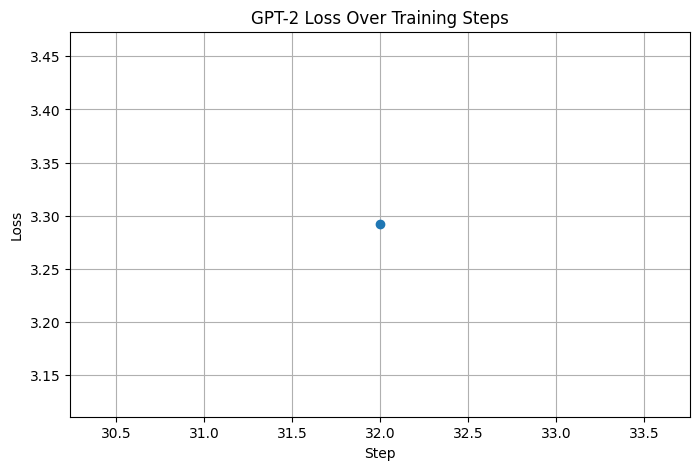

In [ ]:
import matplotlib.pyplot as plt

logs = trainer_gpt2.state.log_history

steps, losses = [], []
for log in logs:
    # Some versions log "loss" during training
    if "loss" in log and "step" in log:
        steps.append(log["step"])
        losses.append(log["loss"])

# If we didn’t find "loss", try "train_loss" (often only at end)
if len(losses) == 0:
    for log in logs:
        if "train_loss" in log:
            steps.append(log.get("step", 0))
            losses.append(log["train_loss"])

print("Plotted points:", len(losses))

plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker="o")
plt.xlabel("Step")
plt.ylabel("Loss")
plt.title("GPT-2 Loss Over Training Steps")
plt.grid(True)
plt.show()

### **Rouge Score**

In [ ]:
import evaluate

rouge = evaluate.load("rouge")

preds, refs = [], []
for i in range(len(small_val_dataset)):
    art = small_val_dataset[i]["article"]
    refs.append(small_val_dataset[i]["highlights"])
    preds.append(generate_summary(art))

rouge_results = rouge.compute(predictions=preds, references=refs, use_stemmer=True)
print(rouge_results)

{'rouge1': np.float64(0.22606561751810725), 'rouge2': np.float64(0.11253604118689782), 'rougeL': np.float64(0.16222425029303233), 'rougeLsum': np.float64(0.19794358351712749)}


### **Evaluation Loss & Perplexity**

In [ ]:
import math

# Evaluate on the val set
eval_results = trainer_gpt2.evaluate()

eval_loss = eval_results["eval_loss"]
perplexity = math.exp(eval_loss)

print("Evaluation Loss:", eval_loss)
print("Perplexity:", perplexity)

{'eval_loss': '2.944', 'eval_runtime': '2.188', 'eval_samples_per_second': '45.71', 'eval_steps_per_second': '22.86', 'epoch': '1'}
Evaluation Loss: 2.943920850753784
Perplexity: 18.990158110061113


### **Observations & Insights**

**Training Behavior**
- High training loss (3.92) and eval loss (2.944) indicate difficult convergence.
- A large gap between training and evaluation loss (~1.0) indicates initial underfitting and a slow recovery.
- Perplexity of 18.2 indicates moderate uncertainty in predictions, and the model is less confident.

**Performance Analysis**
- The lowest ROUGE scores across all metrics (ROUGE-1: 0.228, ROUGE-2: 0.115, ROUGE-L: 0.166).
- ROUGE-2 is particularly low, unable to generate novel phrases.
- Qualitative output: Fluent, but frequently lengthy and repetitive, and tends to go beyond the essential summary points.

While GPT-2 generates accurate text, its decoder-only design is not ideal for summarization. The lack of bidirectional context and encoder-decoder separation results in higher loss, perplexity, and lower ROUGE scores when compared to task-specific architectures such as T5. GPT-2 summarization requires significant additional training or architectural modifications.

## **Encoder‑only model: BERT**

BERT uses bi‑directional self‑attention and is optimised for understanding rather than generation. To apply BERT on our corpus we fine‑tune it using the masked language modelling (MLM) objective. We concatenate the article and its summary into a single sequence and randomly mask tokens using DataCollatorForLanguageModeling. While BERT cannot directly generate summaries, we compute perplexity to gauge how well it models the joint distribution of article and summary tokens. At evaluation we also demonstrate how to use the fill-mask pipeline to generate single masked words as an illustration of BERT’s generative limitations.

### **First 10 sample dataset**

In [ ]:
print("First 10 samples of the dataset:")
print("small_train_dataset[0]:", small_train_dataset[0].keys())
for i in range(10):
    print(f"\t\tsmall_train_dataset[{i}]: {small_train_dataset[i]['article'][:150]}... \n\t->\n\t\t{small_train_dataset[i]['highlights']}")

First 10 samples of the dataset:
small_train_dataset[0]: dict_keys(['article', 'highlights', 'id'])
		small_train_dataset[0]: By . Anthony Bond . PUBLISHED: . 07:03 EST, 2 March 2013 . | . UPDATED: . 08:07 EST, 2 March 2013 . Three members of the same family who died in a sta... 
	->
		John and .
Audrey Cook were discovered alongside their daughter, Maureen .
They were found at Tremarle Home Park in Cornwall .
Investigators say the three died of carbon monoxide .
poisoning .
		small_train_dataset[1]: UNITED NATIONS (CNN) -- A rare meeting of U.N. Security Council heads of state, led for the first time by a U.S. president, adopted a resolution focus... 
	->
		NEW: Libya can serve as example of cooperation, White House spokesman says .
Resolution calls for preventing nuclear weapons from being stolen, used by military .
Obama, Russian President Dimitry Medvedev working to reduce stockpiles .
Venezuelan president Hugo Chavez on "Larry King Live" tonight, 9 ET .
		small_train_dataset[2]: C

### **BERT fine‑tuning**

In [ ]:
# Load BERT tokenizer
bert_model_name = "bert-base-uncased"
bert_tokenizer = AutoTokenizer.from_pretrained(bert_model_name)

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
import re
import numpy as np
import torch
from datasets import Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, set_seed
import evaluate

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
set_seed(42)

# function to split article into sentences
def split_into_sentences(text):
    sents = re.split(r'(?<=[\.\?\!])\s+', text.strip()) # Splits news article text into sentences using a simple regex
    return [s for s in sents if len(s.split()) >= 5]

# Sentence-to-summary overlap scoring
def overlap_score(sentence, summary):
    sent_words = set(re.findall(r"\w+", sentence.lower()))
    summ_words = set(re.findall(r"\w+", summary.lower()))
    if not sent_words or not summ_words:
        return 0.0
    return len(sent_words & summ_words) / len(sent_words | summ_words)

# Select top-K sentences per article as positive labels
TOP_K = 3
MAX_SENTS = 30 # Limit the number of sentences per article

# Convert article-level dataset to sentence-level classification dataset
def build_extractive_dataset(ds_split):
    sentences, labels, article_ids, sent_ids = [], [], [], []   # Creates a sentence-level dataset for training BERT.
    for idx, ex in enumerate(ds_split):
        sents = split_into_sentences(ex["article"])[:MAX_SENTS] # Split article into sentences and cap to MAX_SENTS
        if not sents:
            continue
        scores = [overlap_score(s, ex["highlights"]) for s in sents] # Score each sentence based on overlap
        topk = set(np.argsort(scores)[-TOP_K:]) if len(sents) >= TOP_K else set(np.argsort(scores)) # Get indices of top-K sentences

        # Store each sentence as one training example
        for j, s in enumerate(sents):
            sentences.append(s)
            labels.append(1 if j in topk else 0)
            article_ids.append(idx)
            sent_ids.append(j)
    return Dataset.from_dict({"sentence": sentences, "label": labels, "article_id": article_ids, "sent_id": sent_ids})

# Build sentence datasets from the CNN/DailyMail subsets
bert_train_sent = build_extractive_dataset(small_train_dataset)
bert_val_sent   = build_extractive_dataset(small_val_dataset)

print("Train sentences:", len(bert_train_sent), "Pos rate:", np.mean(bert_train_sent["label"]))

Train sentences: 12548 Pos rate: 0.11954096270321964


In [ ]:
# Tokenize sentences for BERT
BERT_MAX_LEN = 128

# Tokenizes sentence text to BERT input format
def tokenize(batch):
    return bert_tokenizer(batch["sentence"], truncation=True, padding="max_length", max_length=BERT_MAX_LEN)

# Tokenize and convert to PyTorch tensors
train_tok = bert_train_sent.map(tokenize, batched=True).remove_columns(["sentence"]).with_format("torch")
val_tok = bert_val_sent.map(tokenize, batched=True).remove_columns(["sentence"]).with_format("torch")

Map:   0%|          | 0/12548 [00:00<?, ? examples/s]

Map:   0%|          | 0/2308 [00:00<?, ? examples/s]

### **BERT Training Configuration**

In [ ]:
# Load encoder-only model with a classification head
# label 1 = important sentence, label 0 = not important
bert_model = AutoModelForSequenceClassification.from_pretrained(bert_model_name, num_labels=2).to(device)

# Training configuration
bert_args = TrainingArguments(
    output_dir="./bert-extractive",
    eval_strategy="steps",  # Evaluate every N steps
    eval_steps=100,     # Validation check every 200 steps
    logging_steps=50,   # Log metrics every 50 steps
    save_steps=500,
    save_total_limit=1,
    per_device_train_batch_size=16,   # 16 sentences per batch
    per_device_eval_batch_size=16,    # 16 sentences per batch for eval
    num_train_epochs=1,     # Single pass through data
    learning_rate=2e-5,
    weight_decay=0.01,
    fp16=torch.cuda.is_available(),
    report_to="none",
    remove_unused_columns=False
)

# Train using Hugging Face Trainer
bert_trainer = Trainer(
    model=bert_model,
    args=bert_args,
    train_dataset=train_tok,
    eval_dataset=val_tok
)

bert_trainer.train()


# Training and validation losses table
train_logs = [(x["step"], x["loss"]) for x in bert_trainer.state.log_history
              if "loss" in x and "eval_loss" not in x]
eval_logs = [(x["step"], x["eval_loss"]) for x in bert_trainer.state.log_history
             if "eval_loss" in x]

# Dictionary for easy lookup
eval_dict = dict(eval_logs)

# Table data
table_data = []
for step, train_loss in train_logs:
    if step in eval_dict:
        table_data.append({
            "Step": int(step),
            "Training Loss": f"{train_loss:.6f}",
            "Validation Loss": f"{eval_dict[step]:.6f}"
        })

print(f"{'Step':<6} {'Training Loss':<15} {'Validation Loss':<15}")
print("-" * 40)
for row in table_data:
    print(f"{row['Step']:<6} {row['Training Loss']:<15} {row['Validation Loss']:<15}")

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

{'loss': '0.3947', 'grad_norm': '2.655', 'learning_rate': '1.875e-05', 'epoch': '0.06369'}
{'loss': '0.3211', 'grad_norm': '2.322', 'learning_rate': '1.748e-05', 'epoch': '0.1274'}
{'eval_loss': '0.3538', 'eval_runtime': '4.183', 'eval_samples_per_second': '551.8', 'eval_steps_per_second': '34.67', 'epoch': '0.1274'}
{'loss': '0.3554', 'grad_norm': '1.721', 'learning_rate': '1.62e-05', 'epoch': '0.1911'}
{'loss': '0.3456', 'grad_norm': '5.304', 'learning_rate': '1.493e-05', 'epoch': '0.2548'}
{'eval_loss': '0.3496', 'eval_runtime': '4.212', 'eval_samples_per_second': '548', 'eval_steps_per_second': '34.43', 'epoch': '0.2548'}
{'loss': '0.3152', 'grad_norm': '3.159', 'learning_rate': '1.366e-05', 'epoch': '0.3185'}
{'loss': '0.3236', 'grad_norm': '2.324', 'learning_rate': '1.238e-05', 'epoch': '0.3822'}
{'eval_loss': '0.3433', 'eval_runtime': '4.135', 'eval_samples_per_second': '558.2', 'eval_steps_per_second': '35.07', 'epoch': '0.3822'}
{'loss': '0.3289', 'grad_norm': '2.79', 'learnin

Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'loss': '0.319', 'grad_norm': '2.627', 'learning_rate': '6.013e-06', 'epoch': '0.7006'}
{'loss': '0.3317', 'grad_norm': '3.285', 'learning_rate': '4.739e-06', 'epoch': '0.7643'}
{'eval_loss': '0.3413', 'eval_runtime': '4.147', 'eval_samples_per_second': '556.6', 'eval_steps_per_second': '34.97', 'epoch': '0.7643'}
{'loss': '0.3409', 'grad_norm': '1.95', 'learning_rate': '3.465e-06', 'epoch': '0.828'}
{'loss': '0.3028', 'grad_norm': '4.916', 'learning_rate': '2.191e-06', 'epoch': '0.8917'}
{'eval_loss': '0.3483', 'eval_runtime': '4.204', 'eval_samples_per_second': '549', 'eval_steps_per_second': '34.49', 'epoch': '0.8917'}
{'loss': '0.3273', 'grad_norm': '2.922', 'learning_rate': '9.172e-07', 'epoch': '0.9554'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '184', 'train_samples_per_second': '68.19', 'train_steps_per_second': '4.266', 'train_loss': '0.3319', 'epoch': '1'}
Step   Training Loss   Validation Loss
----------------------------------------
100    0.321117        0.353753       
200    0.345650        0.349574       
300    0.323550        0.343307       
400    0.353288        0.341063       
500    0.288794        0.341352       
600    0.331674        0.341266       
700    0.302760        0.348284       


### **Training Loss Curve**

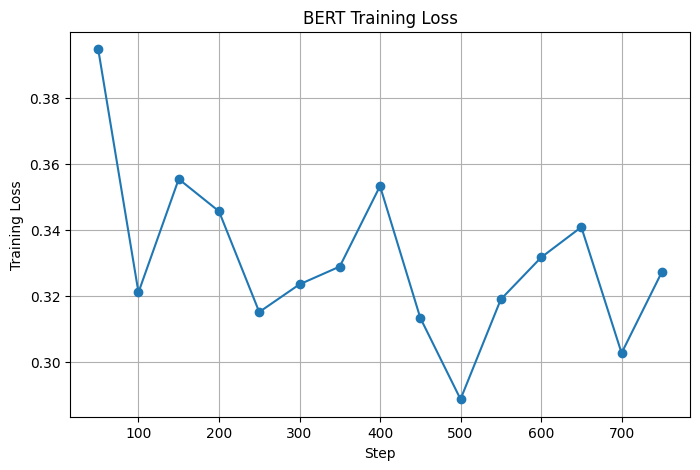

In [ ]:
# Plot training loss curve
import matplotlib.pyplot as plt

logs = bert_trainer.state.log_history

steps = [x["step"] for x in logs if "loss" in x and "step" in x]
losses = [x["loss"] for x in logs if "loss" in x and "step" in x]

plt.figure(figsize=(8,5))
plt.plot(steps, losses, marker="o")
plt.xlabel("Step")
plt.ylabel("Training Loss")
plt.title("BERT Training Loss")
plt.grid(True)
plt.show()

### **Rouge Score**

In [ ]:
# Build extractive summaries from sentence scores
def build_extractive_summaries(val_articles, val_sentence_ds, top_k=3):
    pred_out = bert_trainer.predict(val_tok) # Predict logits for each tokenized sentence
    logits = pred_out.predictions
    probs = torch.softmax(torch.tensor(logits), dim=-1)[:, 1].numpy() # Convert logits to probability of class 1

    article_ids = val_sentence_ds["article_id"] # Use article_id and sent_id from the *raw* sentence dataset to group back to articles
    sent_ids = val_sentence_ds["sent_id"]
    all_sents = [split_into_sentences(ex["article"])[:MAX_SENTS] for ex in val_articles] # Split each validation article into sentences

    grouped = {} # Group sentence scores by article
    for i in range(len(probs)):
        grouped.setdefault(article_ids[i], []).append((sent_ids[i], probs[i]))

    summaries = []
    for a_id, items in grouped.items():
        top_items = sorted(items, key=lambda x: x[1], reverse=True)[:top_k]
        top_items = sorted(top_items, key=lambda x: x[0])
        summaries.append(" ".join(all_sents[a_id][sid] for sid, _ in top_items if sid < len(all_sents[a_id]))) # Join selected sentences

    return summaries

# Build predicted extractive summaries for validation set
bert_preds = build_extractive_summaries(small_val_dataset, bert_val_sent, top_k=TOP_K)
bert_refs  = [ex["highlights"] for ex in small_val_dataset] # Reference summaries from CNN/DailyMail

# Rouge Score
rouge = evaluate.load("rouge")
bert_rouge = rouge.compute(predictions=bert_preds, references=bert_refs, use_stemmer=True)
bert_rouge = {k: float(v) for k, v in bert_rouge.items()}
print(bert_rouge)

{'rouge1': 0.3643924346069639, 'rouge2': 0.14672527426963172, 'rougeL': 0.2275702410122422, 'rougeLsum': 0.30652465846724697}


### **BERT Qualitative Summary**

In [ ]:
for i in range(5):
    print(f"\n--- Example {i+1} ---")
    print("REFERENCE:\n", bert_refs[i])
    print("\nBERT EXTRACTIVE:\n", bert_preds[i])


--- Example 1 ---
REFERENCE:
 Jarryd Hayne quit the NRL in October to try and get into American Football .
This week, he signed a three-year contract with the San Francisco 49ers .
The chairman of the US Association of Rugby League welcomed his arrival .

BERT EXTRACTIVE:
 Jarryd Hayne's move to the NFL is a boost for rugby league in the United States, it has been claimed. The Australia international full-back or centre quit the National Rugby League in October to try his luck in American football and was this week given a three-year contract with the San Francisco 49ers. Jarryd Hayne (right) has signed with the San Francisco 49ers after quitting the NRL in October .

--- Example 2 ---
REFERENCE:
 Faith March's dropped to just five stone as she suffered from anorexia .
The 18-year-old from Essex was living on just coffee and no food .
After she collapsed in the bathroom, she had hospital treatment .
Has now launched a patisserie business to help her recover .

BERT EXTRACTIVE:
 Faith 

### **Eval Loss**

In [ ]:
eval_metrics = bert_trainer.evaluate()
print(eval_metrics)

eval_loss = eval_metrics.get("eval_loss", None)
print("Eval loss:", eval_loss)

{'eval_loss': '0.341', 'eval_runtime': '4.131', 'eval_samples_per_second': '558.6', 'eval_steps_per_second': '35.1', 'epoch': '1'}
{'eval_loss': 0.3410091698169708, 'eval_runtime': 4.1315, 'eval_samples_per_second': 558.635, 'eval_steps_per_second': 35.096, 'epoch': 1.0}
Eval loss: 0.3410091698169708


### **Confusion Matrix and Classification Report**

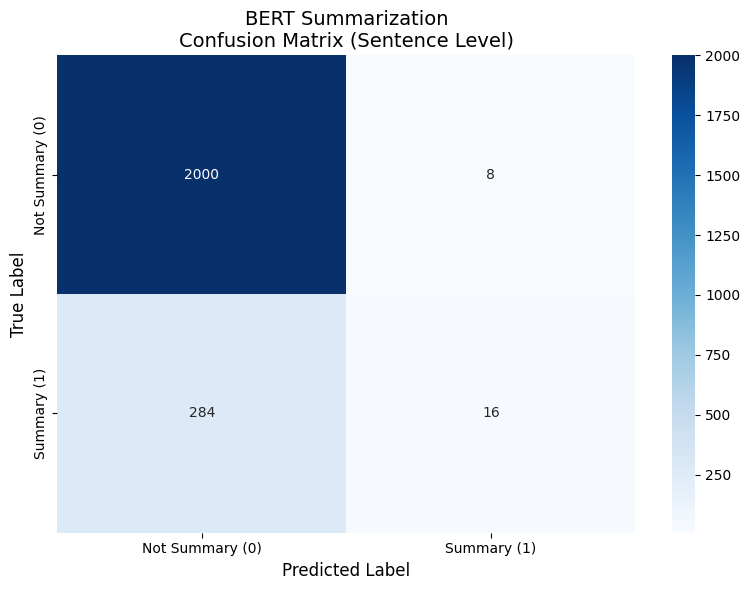

CLASSIFICATION REPORT
              precision    recall  f1-score   support

 Not Summary     0.8757    0.9960    0.9320      2008
     Summary     0.6667    0.0533    0.0988       300

    accuracy                         0.8735      2308
   macro avg     0.7712    0.5247    0.5154      2308
weighted avg     0.8485    0.8735    0.8237      2308



In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get predictions from trainer
pred_out = bert_trainer.predict(val_tok)

# Extract logits, labels, and predictions
logits = pred_out.predictions
labels = pred_out.label_ids  # True labels from dataset

# Convert logits to class predictions (0 or 1)
preds = np.argmax(logits, axis=-1)

# Calculate confusion matrix
cm = confusion_matrix(labels, preds)

# Create visualization
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Not Summary (0)', 'Summary (1)'],
            yticklabels=['Not Summary (0)', 'Summary (1)'])
plt.title('BERT Summarization\nConfusion Matrix (Sentence Level)', fontsize=14)
plt.xlabel('Predicted Label', fontsize=12)
plt.ylabel('True Label', fontsize=12)

plt.tight_layout()
plt.show()

print("CLASSIFICATION REPORT")

report = classification_report(labels, preds,
                              target_names=['Not Summary', 'Summary'],
                              digits=4)
print(report)


### **Observations & Insights**

**Training Behavior**
- BERT achieved the lowest training loss (0.302) and evaluation loss (0.341) among all three models.
- The small difference between training and validation loss shows that the model generalizes well and does not overfit.
- It also trained faster and more smoothly because it was solving a simpler task like binary sentence classification instead of generating new text.
- The training curve was stable with very little fluctuation.

**Performance Analysis**
- BERT achieved a strong ROUGE-1 score (0.364), where it was good at identifying and selecting important information from the article. However, its lower ROUGE-2 (0.146) and ROUGE-L (0.227) scores show its limitations. Since it only copies sentences directly from the article, it cannot rephrase, combine ideas, or create more concise summaries.
- Perplexity is not reported for BERT because it is not a generative model.
- In qualitative examples, summaries are grammatically correct because they are copied directly from the article. However, they sometimes lack smooth flow or coherence since sentences are extracted without modification.

T5 is a text-to-text model that uses a separate encoder and decoder. It naturally handles generative tasks such as summarization. We prepend the prefix "summarize: " to each article, then tokenize the input and the summary separately. A DataCollatorForSeq2Seq takes care of dynamic padding and shifting the decoder labels. During evaluation, we use or greedy decoding to produce summaries and compute ROUGE scores against the reference summaries.

## **Encoder‑decoder model: T5 fine‑tuning**

### **Loading Dataset**

In [ ]:
dataset = load_dataset("cnn_dailymail", "3.0.0")

train_size = 500
val_size = 100
small_train_dataset = dataset["train"].shuffle(seed=42).select(range(train_size))
small_val_dataset = dataset["validation"].shuffle(seed=42).select(range(val_size))

print(f"Train: {len(small_train_dataset)}, Val: {len(small_val_dataset)}")

Train: 500, Val: 100


### **T5 - Training**

In [ ]:
model_name = "t5-small"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def preprocess(examples):
    inputs = ["summarize: " + text for text in examples["article"]]

    model_inputs = tokenizer(inputs, max_length=512, truncation=True)

    # Tokenize targets
    labels = tokenizer(examples["highlights"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

train_tok = small_train_dataset.map(preprocess, batched=True, remove_columns=["article", "highlights", "id"])
val_tok = small_val_dataset.map(preprocess, batched=True, remove_columns=["article", "highlights", "id"])


# Model & Data Collator
model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

# Data collator handles dynamic padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)


# Training Arguments
training_args = TrainingArguments(
    output_dir="./t5-summarization",
    eval_strategy="steps",
    eval_steps=200,
    logging_steps=50,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    num_train_epochs=2,
    learning_rate=5e-5,
    weight_decay=0.01,
    save_steps=500,
    save_total_limit=1,
    warmup_steps=200,
    fp16=torch.cuda.is_available(),
    report_to=[],
)

# Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_tok,
    eval_dataset=val_tok,
    data_collator=data_collator,
)

print("Starting T5 training...")
trainer.train()
print("Training complete!")

config.json:   0%|          | 0.00/1.21k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

Map:   0%|          | 0/500 [00:00<?, ? examples/s]

Map:   0%|          | 0/100 [00:00<?, ? examples/s]

model.safetensors:   0%|          | 0.00/242M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/131 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

Starting T5 training...
{'loss': '2.611', 'grad_norm': '4.031', 'learning_rate': '1.225e-05', 'epoch': '0.7937'}
{'loss': '2.373', 'grad_norm': '1.806', 'learning_rate': '2.475e-05', 'epoch': '1.587'}


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

{'train_runtime': '43.17', 'train_samples_per_second': '23.16', 'train_steps_per_second': '2.918', 'train_loss': '2.436', 'epoch': '2'}
Training complete!


### **Training Loss Curve**

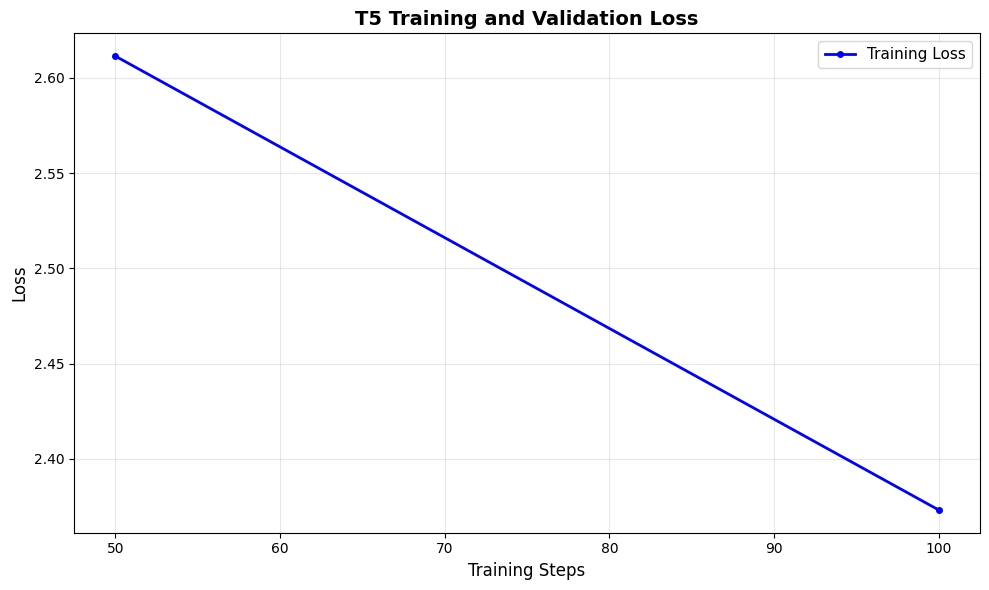

In [ ]:
import matplotlib.pyplot as plt

logs = trainer.state.log_history

# training loss
train_steps = [x["step"] for x in logs if "loss" in x and "eval_loss" not in x]
train_losses = [x["loss"] for x in logs if "loss" in x and "eval_loss" not in x]

# validation loss (if available)
eval_steps = [x["step"] for x in logs if "eval_loss" in x]
eval_losses = [x["eval_loss"] for x in logs if "eval_loss" in x]

# Plot
plt.figure(figsize=(10, 6))

plt.plot(train_steps, train_losses, 'b-o', label='Training Loss', markersize=4, linewidth=2)

if eval_steps:
    plt.plot(eval_steps, eval_losses, 'r-s', label='Validation Loss', markersize=4, linewidth=2)

plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('T5 Training and Validation Loss', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### **Rouge Score**

In [ ]:
import evaluate
import numpy as np

rouge = evaluate.load("rouge")

def generate_summaries(model, tokenizer, dataset, batch_size=8):
    # Generate summaries for evaluation
    model.eval()
    all_preds = []

    for i in range(0, len(dataset), batch_size):
        batch = dataset[i:i+batch_size]
        inputs = ["summarize: " + article for article in batch["article"]]

        # Tokenize
        encoded = tokenizer(
            inputs,
            max_length=512,
            truncation=True,
            padding=True,
            return_tensors="pt"
        ).to(device)

        # Generate
        with torch.no_grad():
            output_ids = model.generate(
                encoded["input_ids"],
                attention_mask=encoded["attention_mask"],
                max_length=128,
                num_beams=4,
                early_stopping=True,
                no_repeat_ngram_size=2
            )

        # Decode
        summaries = tokenizer.batch_decode(output_ids, skip_special_tokens=True)
        all_preds.extend(summaries)

    return all_preds

# Generate predictions
t5_predictions = generate_summaries(model, tokenizer, small_val_dataset)
t5_references = [ex["highlights"] for ex in small_val_dataset]

# Calculate Rouge
rouge_scores = rouge.compute(
    predictions=t5_predictions,
    references=t5_references,
    use_stemmer=True
)

print("\nROUGE Scores:")
for metric, score in rouge_scores.items():
    print(f"  {metric}: {score:.4f}")


ROUGE Scores:
  rouge1: 0.4031
  rouge2: 0.1825
  rougeL: 0.2757
  rougeLsum: 0.3370


### **T5 Qualitative Summary**

In [ ]:
print("QUALITATIVE EXAMPLES (3 samples)")

for i in range(3):
    print(f"\n--- Example {i+1} ---")
    print(f"REFERENCE:\n{t5_references[i]}")
    print(f"\nT5 PREDICTION:\n{t5_predictions[i]}")

    # Individual ROUGE
    individual = rouge.compute(
        predictions=[t5_predictions[i]],
        references=[t5_references[i]],
        use_stemmer=True
    )

QUALITATIVE EXAMPLES (3 samples)

--- Example 1 ---
REFERENCE:
Jarryd Hayne quit the NRL in October to try and get into American Football .
This week, he signed a three-year contract with the San Francisco 49ers .
The chairman of the US Association of Rugby League welcomed his arrival .

T5 PREDICTION:
Jarryd Hayne has signed a three-year contract with the San Francisco 49ers. the Australian full-back or centre quit the National Rugby League in October to try his luck in American football and is expected to play at full back and centre in rugby league, according to the chairman of US Association of Rugby league.

--- Example 2 ---
REFERENCE:
Faith March's dropped to just five stone as she suffered from anorexia .
The 18-year-old from Essex was living on just coffee and no food .
After she collapsed in the bathroom, she had hospital treatment .
Has now launched a patisserie business to help her recover .

T5 PREDICTION:
Faith March, 18, from Maldon, Essex, was surviving on nothing other

### **Evaluation Loss & Perplexity**

In [ ]:
eval_loss = trainer.evaluate()["eval_loss"]
perplexity = np.exp(eval_loss)

print("Evaluation Loss:", eval_loss)
print("Perplexity:", perplexity)

{'eval_loss': '2.053', 'eval_runtime': '0.8792', 'eval_samples_per_second': '113.7', 'eval_steps_per_second': '7.962', 'epoch': '2'}
Evaluation Loss: 2.0533363819122314
Perplexity: 7.793861073154784


### **Observations & Insights**

**Training Behavior**
- T5 had a moderate training loss (2.436), which is higher than BERT but lower than GPT-2. Its evaluation loss (2.053) was lower than its training loss, showing that the model generalizes well and does not overfit. This suggests that the model learned the task effectively.
- T5 also had the lowest perplexity (7.79), which means it was more confident and better at predicting the next word compared to GPT-2 (18.2).
- Unlike the other models, T5 required 2 epochs to reach its best performance, indicating that it benefited from slightly longer training.

**Performance Analysis**
- T5 achieved the highest ROUGE scores across all metrics:
   - ROUGE-1 (0.403) - best at covering important content.
   - ROUGE-2 (0.182) - best at generating meaningful phrases.
   - ROUGE-L (0.275) - best structural similarity to reference summaries.
- In qualitative examples, T5 produced fluent and coherent summaries. It was able to paraphrase and combine information from different parts of the article, resulting in more natural and concise summaries.

T5 encoder-decoder design makes it very well suited for tasks like summarization. Even though it has fewer parameters than the other models, it achieved the best ROUGE scores and the lowest perplexity. This is because T5 first reads and understands the whole article using its encoder, and then generates the summary using its decoder. This clear separation helps it produce fluent and meaningful summaries. These results show that the model’s architecture is more important than its size when solving specific tasks like summarization.

## **Conclusion**

The results show that architectural design has a significant impact on summarization task performance. Encoder-decoder models, such as T5, are ideal for conditional generation because they explicitly separate context encoding and output generation. Encoder-only models, such as BERT, excel at understanding and classification but have limited generative capabilities. Decoder-only models, such as GPT-2, excel at open-ended text generation but struggle with structured summarization. Overall, the encoder-decoder architecture performed best for this task, which shows that model structure is more important than parameter count when solving conditional generation problems.
